# Esercizio 5 - Topic Modeling

### Un po' di teoria

In questo esercizio andremo ad utilizzare la libreria gensim per fare il topic modeling, sfruttando l'algoritmo **Latent Dirichlet Allocation**
(LDA). E' un modello *non supervisionato* in quanto non necessita di un dataset annotato per fare il training, il che lo rende un algoritmo 
estremamente versatile e facile da utilizzare.

**Cos'è un topic?**
Un topic è un insieme di keyword dominanti che, dovrebbero, essere rappresentative del topic.

**I fattori chiave per ottenere buoni argomenti di segregazione sono i seguenti:**
- La qualità dell'elaborazione del testo
- La varietà di argomenti di cui parla il testo
- La scelta dell'algoritmo di modellazione degli argomenti
- Il numero di argomenti da fornire all'algoritmo
- I parametri di regolazione dell'algoritmo

**Il funzionamento di questa libreria ruota attorno a 4 concetti:**

- **Document**: del testo - una sequenza di parole
  
- **Corpus**: una collezione di documenti
- **Vector**: convenzione tramite cui rappresentiamo il testo. Ciò ci permette di avere una rappresentazione matematica del testo 
  che abilità una serie di operazioni. In sostanza è una sequenza di numeri che rappresenta un documento.
- **Model**: è un algoritmo che permette di trasformare un vettore da una rappresentazione ad un'altra. E' il modello che viene
  utilizzato per fare il topic modeling.

### Imports

In [3]:
import re
import pandas as pd
from pprint import pprint

# Gensim
import gensim
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

## Corpus

### Preparazione del dataset

Come dataset abbiamo selezionato da kaggle *"20-Newsgroups"* (https://www.kaggle.com/datasets/crawford/20-newsgroups) che contiene circa 18mila documenti di newsgroup,
che non sono altro che dei post scritti su un determinato argomento, in questo caso abbiamo 20 argomenti diversi.

In [4]:
# Import Dataset
df = pd.read_json('../data/tm_data.json')

In [5]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


### Analiziamo il dataset

In [6]:
#topics
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [7]:
# Pick the contents and put them into a list
data = []
for content in df['content']:
    data.append(content)

### Processing the data

Puliamo il dataset, rimuovendo le porzioni di testo che non ci interessano e che potrebbero compromettere le performance del modello.

In [8]:
#clean the data removing useless stuff
cleaned_data = []

for line in data:
        line = line.lower() #lowercase   
        line = re.sub('\S*@\S*\s?', '', line) #remove e-mails
        line = re.sub('\s+', ' ', line) #remove new lines
        line = re.sub("\'", '', line) #remove single quotes
        cleaned_data.append(line.strip())

### Tokenization

Tokenizziamo le parole utilizzando la comodissima funzione simple_preprocess di Gensim

In [9]:
#tokenize with Gensim’s simple_preprocess()
def split_sentence(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))    

words1 = list(split_sentence(cleaned_data))

### Prepariamo i dati (bigrammi e trigrammi) per il modello di gensim

Ora entriamo nel vivo dell'esercizio, vediamo il funzionamento del modello *gensim.models.Phrases*:

(Dalla documentazione ufficiale) --> *Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a 
stream of sentences.*

E ancora: *Detect phrases based on collocation counts.*


**Analizziamo i parametri:**

- *sentences* = words1 --> Gli passiamo le frasi tokenizzate da analizzare
  
- *min_count* = 5 --> Il numero minimo di occorrenze di una parola per essere considerata (default = 5)
- *threshold* = 100 --> *A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold - (higher means fewer phrases)*
- *connector_words* = ENGLISH_CONNECTOR_WORDS --> Rappresenta una lista di parole che possono essere presenti in una frase senza che lo score della
frase venga incrementato.

Più saranno alti i valori di *min_count* e *threshold*, più sarà difficile che vengano formati dei bigrammi e dei trigrammi.

**Bigrams** --> Coppia di parole che compaiono spesso assieme nel documento

**Trigrams** --> Triple parole che compaiono spesso assieme nel documento

In [10]:
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

bigram = gensim.models.Phrases(words1, min_count=5, threshold=100, 
                              connector_words=ENGLISH_CONNECTOR_WORDS)

trigram = gensim.models.Phrases(bigram[words1], threshold=100, 
                               connector_words=ENGLISH_CONNECTOR_WORDS)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting', 'host', 'rac_wam', 'umd_edu', 'organization', 'university', 'of', 'maryland_college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']
['from', 'wheres', 'my', 'thing', 'subject', '

Riassumiamo all'interno di alcuni metodi i passi principali:

In [11]:
def remove_stopwords(text):
    '''Remove stopwords from text'''
    return [[w for w in simple_preprocess(str(content)) if w not in stopwords] for content in text]

def build_bigrams(text):
    '''construct bigrams from text '''
    return [bigram_mod[content] for content in text]

def build_trigrams(text):
    '''construct trigrams from text'''
    return [trigram_mod[bigram_mod[content]] for content in text]

def lemmatizer(text, pos=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """It assign general context to words in text 
       source: https://spacy.io/api/annotation"""
    output = []
    for s in text:
        content = nlp(" ".join(s)) 
        output.append([tkn.lemma_ for tkn in content if tkn.pos_ in pos])
    return output

In [12]:
# Remove Stop Words
words_cleaned = remove_stopwords(words1)

# Form Bigrams
words_bigrams = build_bigrams(words_cleaned)

#Form Trigrams
words_trigrams = build_trigrams(words_cleaned)

### Lemmatization

In [13]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [14]:
# Do lemmatization keeping only noun, adj, vb, adv
lemmatization = lemmatizer(words_bigrams, pos=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(lemmatization[0])
len(lemmatization[0])

['thing', 'subject', 'car', 'nntp_poste', 'host', 'rac_wam', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


48

## Vectors

### Trasformiamo i termini in vettori per poterli maneggiare con più semplicità in Gensim

I due elementi principali di cui ha bisogno il modello LDA sono il **corpus** e il **dictionary**, andiamo a costruire il dizionario.

Gensim crea un id unico per ogni parla nel documento. Dopo di crea una lista di coppie **(word_id, word_frequency)**

In [23]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary


#Create Dictionary -> assign id to words
#common_dictionary = Dictionary(lemmatization)

common_dictionary = Dictionary(words_cleaned)
#Create Corpus
#Term Document Frequency
#common_corpus = [common_dictionary.doc2bow(text) for text in lemmatization]
common_corpus = [common_dictionary.doc2bow(text) for text in words_cleaned]
#Gensim creates a unique id for each word in the document. 
#The produced corpus shown above is a mapping of (word_id, word_frequency).
print(common_corpus[0])
len(common_corpus[0])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1)]


60

## Modello

Ora che abbiamo i dati ripuliti e trasformati in vettori possiamo procedere con il training del modello.

Vediamo alcuni iperparametri che possono essere utilizzati per il training del modello:

- *alpha* and *eta* --> Vanno ad influenzare la sparità dei topic. Di base sono settati a *1.0/num_topics*
  
- *chunchsize* --> Numero di documenti da analizzare per ogni iterazione
- *update_every* --> Determina la frequenza con cui i parametri del modello devono essere aggiornati
- *passes* --> E' il numero totale di passaggi di addestramento

In [24]:
from gensim.models.ldamodel import LdaModel

# Train the model on the corpus.
lda = LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=20, per_word_topics=True)

In [25]:
#Each topic is a combination of keywords which contributes a certain weightage to the topic itself.
pprint(lda.print_topics())

[(0,
  '0.008*"people" + 0.008*"one" + 0.007*"would" + 0.006*"israel" + '
  '0.006*"said" + 0.006*"god" + 0.005*"jews" + 0.005*"israeli" + 0.004*"jesus" '
  '+ 0.004*"us"'),
 (1,
  '0.019*"space" + 0.008*"nasa" + 0.005*"orbit" + 0.004*"program" + '
  '0.004*"earth" + 0.004*"lines" + 0.004*"organization" + 0.004*"subject" + '
  '0.004*"shuttle" + 0.004*"moon"'),
 (2,
  '0.012*"church" + 0.010*"jesus" + 0.006*"one" + 0.005*"spirit" + '
  '0.005*"subject" + 0.005*"catholic" + 0.004*"would" + 0.004*"lines" + '
  '0.004*"bible" + 0.004*"organization"'),
 (3,
  '0.537*"ax" + 0.040*"max" + 0.010*"ei" + 0.007*"di" + 0.006*"cx" + '
  '0.006*"pl" + 0.005*"um" + 0.004*"el" + 0.004*"bhj" + 0.003*"ql"'),
 (4,
  '0.010*"comet" + 0.009*"insurance" + 0.008*"health" + 0.007*"jupiter" + '
  '0.007*"dare" + 0.007*"gary" + 0.006*"wa" + 0.006*"gehrels" + 0.006*"c_" + '
  '0.005*"temporary"'),
 (5,
  '0.009*"lines" + 0.008*"subject" + 0.008*"organization" + 0.007*"team" + '
  '0.006*"year" + 0.006*"writes" 

***Come interpretiamo i risultati?***

Ci viene ritornata una lista di elementi, il primo elemento corrisponde al numero del topic (da 0 a 19 = 20 topic).

Il secondo elemento invece è una lista di parole con un peso associato, il peso corrisponde a quanto quella parola è presente nel topic, e di 
conseguenza quanta importanza ha nel determinare il topic. Ad esempio se prendiamo l'ultimo topic, il 19, possiamo notare come le prime 3 parole,
che corrispondono a quelle con un peso maggiore e che quindi sono più importanti nel topic, sono *lunch*, *space* e *satellite*. 
Questo ci suggerische che probabilmente quel topic parla di satelliti / spazio / razzi.

### Wordcloud dei risultati ottenuti

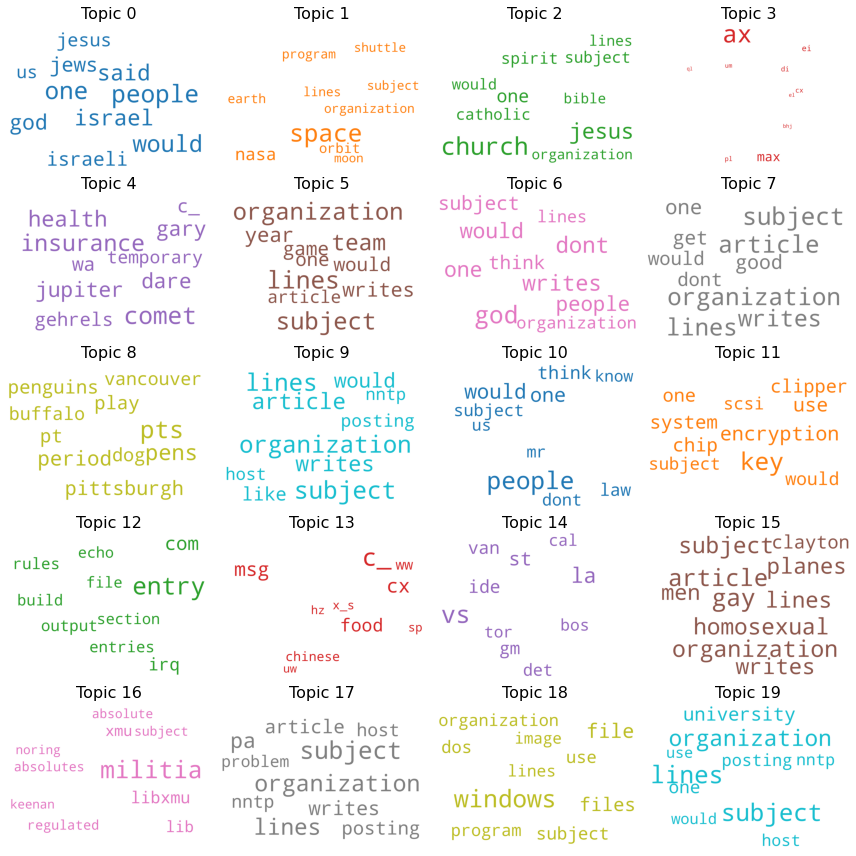

In [26]:
# Wordcloud of Top N words in each topic
# word cloud with the size of the words proportional to the weight
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[-10+i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(5, 4, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()